In [8]:
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np 
from IPython.display import Audio
import random
import librosa
from librosa import display

## Nyquist-Shannon theorem

* A signal containing no frequency components above x Hz is completely determined by specifying its values on a discrete grid with strictly more than 2x time-points per second.

* We only care to represent frequency components up to ~20000Hz (human hearing range), hence framerate > 40000 frames/s. Typical value is 44100 frames/s.

In [2]:
FRAMERATE = 44100

# Wav representation

* Discretize time: fixed number of frames per second (framerate)
* Compute the value of a sinusoid at each time frame
* The resulting array of values is a representation of the sound wave

In [3]:
def sine(freq = 440, duration = 1, framerate = FRAMERATE):
    #Returns array of sine-wave values with given frequency (in Hz) and duration (in s)
    
    t = np.linspace(0, duration, framerate * duration) # create temporal grid (one time-point per frame)
    wave = np.sin(2 * np.pi * freq * t) # each timepoint is assigned the value of the sine wave with frequency freq at that time point
    
    return wave


pure_sinusoid = sine(220)
pure_sinusoid

array([ 0.00000000e+00,  3.13402667e-02,  6.26497429e-02, ...,
       -6.26497429e-02, -3.13402667e-02,  3.13806691e-14])

In [30]:
len(pure_sinusoid)

44100

In [4]:
def play_sound(wave, framerate = FRAMERATE):
    #Plays a sound wave expressed as an array of values
    return Audio(wave, rate = framerate, autoplay=True)

play_sound(pure_sinusoid)

# Additive synthesis

In [5]:
def silence(duration, framerate = FRAMERATE):
    #Returns array of silence
    t = np.linspace(0, duration, framerate * duration)
    
    return 0*t


def synthesis(waves, framerate = FRAMERATE):
    #Returns additive synthesis of a list of waves (padding with silence if length is unequal)
    
    max_length = max([len(wave) for wave in waves])
    uniform_waves = [np.concatenate([wave, silence((max_length-len(wave))/framerate)]) for wave in waves] #all waves reach max_length
        
    return sum(uniform_waves)  

harmonic_sound = synthesis([sine(220*k) for k in range(1, 10)])
harmonic_sound

array([ 0.00000000e+00,  1.40017909e+00,  2.73890045e+00, ...,
       -2.73890045e+00, -1.40017909e+00, -8.61606644e-13])

In [6]:
play_sound(harmonic_sound)

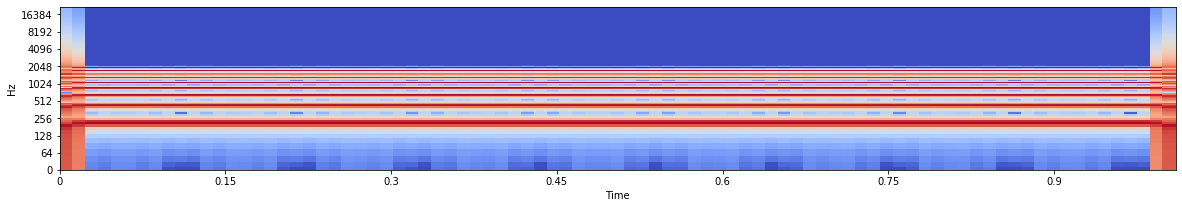

In [9]:
def show_spectrogram(wave):
    #Shows spectrogram of input wave
    X = librosa.stft(wave)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=FRAMERATE, x_axis='time', y_axis='log')

show_spectrogram(harmonic_sound)

# Envelope

Multiply soundwave by a function describing the shape of the envelope

In [10]:
def exp_decay(wave, coef = 5, framerate = FRAMERATE):
    duration = len(wave)/framerate
    t = np.linspace(0, duration, framerate * duration)
    return np.exp(-coef*t)*wave

exponential_decay = exp_decay(harmonic_sound)

In [11]:
play_sound(exponential_decay)

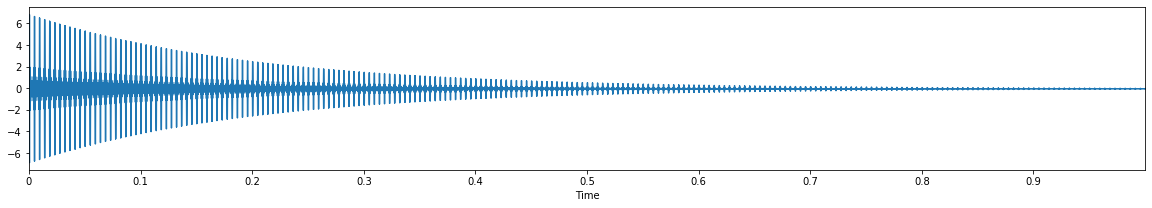

In [12]:
librosa.display.waveplot(exponential_decay, sr=FRAMERATE);

## An example
* Two sounds (1s and 2s). 
* Each sound has an overarching 2Hz sinusoidal envelope. 
* First sound is a 440Hz sinusoid. 
* Second sound is a harmonic complex with 10 partials with decreasing amplitude. Each partial decays exponentially over a progressively decreasing duration (the timbre of the second sound changes over its 2s duration).

In [31]:
sound_blobs = sine(freq = 2, duration = 3)*np.concatenate([exp_decay(sine(440)), synthesis([(1/k)*exp_decay(sine(freq = 220*k, duration = 2/k)) for k in range(1, 10)])])
play_sound(sound_blobs)

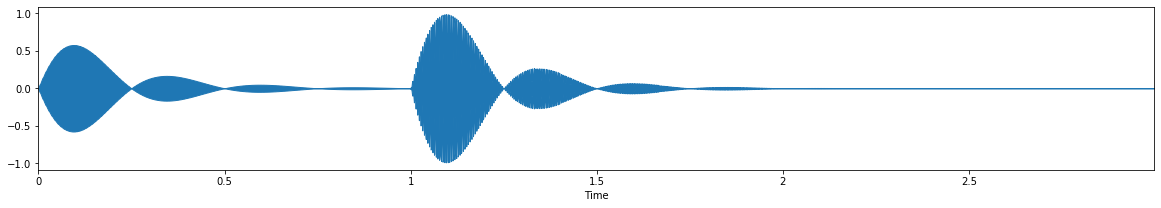

In [24]:
librosa.display.waveplot(sound_blobs, sr=FRAMERATE);

## Attack, Decay, Sustain, Release

In [27]:
def lin_envelope(wave, start_level = 1, end_level = 0,  framerate = FRAMERATE):
    # Linear envelope
    t = np.linspace(start_level, end_level, len(wave))
    return t*wave
    
def envelope(wave, decay_amplitude, split, begin = 0, end = 0):
    #Apply ADSR envelope to wave. Decay amplitude is expressed as a fraction of 1, splits is a 3-ple of fractions of the duration of wave

    attack = lin_envelope(wave[:int(len(wave)*split[0])], start_level = begin, end_level = 1)
    decay = lin_envelope(wave[int(len(wave)*split[0]):int(len(wave)*split[1])], start_level = 1, end_level = decay_amplitude)
    sustain = decay_amplitude*wave[int(len(wave)*split[1]):int(len(wave)*split[2])]
    release = lin_envelope(wave[int(len(wave)*split[2]):], start_level = decay_amplitude, end_level = end)
    
    return np.concatenate([attack, decay, sustain, release])


sound_with_envelope = envelope(harmonic_sound, 1/10, [1/10, 2/10, 9/10])
play_sound(sound_with_envelope)

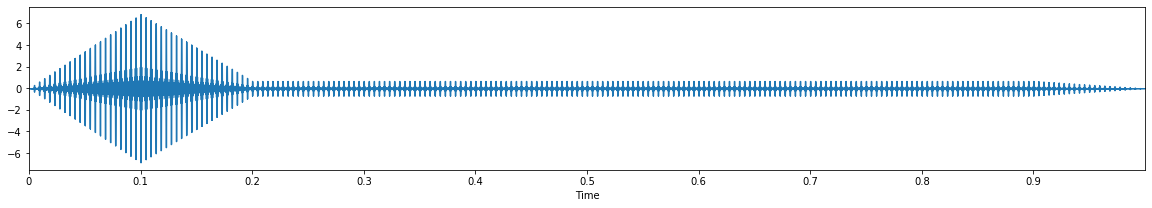

In [29]:
librosa.display.waveplot(sound_with_envelope, sr=FRAMERATE);